# Module 3: Push Notifications DS

## Import libraries

In [26]:
import os
import boto3
import logging
import numpy as np
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, f1_score, confusion_matrix

logging.basicConfig(
    level=logging.INFO,  # Info level for general information
    format="%(asctime)s - %(levelname)s - %(message)s",
)

## Load dataset

In [27]:
load_dotenv()
AWW_API_KEY = os.getenv("AWW_API_KEY")
AWW_SECRET = os.getenv("AWW_SECRET")

s3 = boto3.client(
    's3',
    aws_access_key_id=AWW_API_KEY,
    aws_secret_access_key=AWW_SECRET
)
bucket_name = 'zrive-ds-data'
prefix = "groceries/box_builder_dataset/"

PROJECT_ROOT = Path().resolve().parent.parent
DATA_DIR = PROJECT_ROOT / "data"
DATA_DIR.mkdir(exist_ok=True)

logging.info(f"Data folder: {DATA_DIR}")

response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

for obj in response.get("Contents", []):
    file_key = obj["Key"]
    if file_key.endswith("/"):  # skip folder placeholders
        continue

    # Strip the first folder ('groceries/') and keep the inner folders
    relative_path = Path(*file_key.split("/")[1:])
    local_path = DATA_DIR / relative_path
    local_path.parent.mkdir(parents=True, exist_ok=True)

    if local_path.exists():
        logging.info(f"Already exists: {local_path}, skipping download.")
    else:
        s3.download_file(bucket_name, file_key, str(local_path))
        logging.info(f"Downloaded {local_path}")

2025-10-20 08:34:02,888 - INFO - Data folder: /Users/maria/Desktop/Zrive DS/zrive-ds/data


2025-10-20 08:34:03,542 - INFO - Already exists: /Users/maria/Desktop/Zrive DS/zrive-ds/data/box_builder_dataset/feature_frame.csv, skipping download.


In [28]:
df = pd.read_csv(DATA_DIR / "box_builder_dataset" / "feature_frame.csv")
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


## Milestone 1: exploration phase

### Filter to at least 5 items bought

In [29]:
orders_with_5plus = (
    df[df["outcome"] == 1]              # only buy orders
      .groupby("order_id")["variant_id"]
      .nunique()                        # count unique variant_id por order_id
      .loc[lambda x: x >= 5]            # take >= 5 items
      .index                            # get the order_id index
)

df_filtered = df[df["order_id"].isin(orders_with_5plus)]


In [30]:
logging.info(f"Original dataset size: {df.shape[0]} rows")
logging.info(f"Filtered dataset size: {df_filtered.shape[0]} rows")
df_filtered.head()

2025-10-20 08:34:13,462 - INFO - Original dataset size: 2880549 rows
2025-10-20 08:34:13,465 - INFO - Filtered dataset size: 2163953 rows


,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


### Prepare the data

First, we separe the target from the other features and drop the columns not needed.

In [31]:
X = df_filtered[["variant_id", "product_type", "ordered_before", "abandoned_before", "active_snoozed", "set_as_regular", "global_popularity"]]
y = df_filtered["outcome"]

The next step is transforming the categorical features into numericals to train the model. As we have so many categories in `product_type` one-hot encoding would increase the df size a lot, so we have to use a different encoding method. The final idea was to use frequency encoding because other, such as label encoding, create an inexisting order.

In [32]:
X_encoded = X.copy()
freq_map = X_encoded['product_type'].value_counts(normalize=True)
X_encoded['product_type'] = X_encoded['product_type'].map(freq_map)
X_encoded.head()

,variant_id,product_type,ordered_before,abandoned_before,active_snoozed,set_as_regular,global_popularity
0,33826472919172,0.044619,0.0,0.0,0.0,0.0,0.000000
1,33826472919172,0.044619,0.0,0.0,0.0,0.0,0.000000
2,33826472919172,0.044619,0.0,0.0,0.0,0.0,0.000000
3,33826472919172,0.044619,0.0,0.0,0.0,0.0,0.038462
5,33826472919172,0.044619,0.0,0.0,0.0,0.0,0.038462


Now, we split the data intro train (70%), validation (20%) and test (10%).

In [33]:
X_train, X_val, y_train, y_val = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=0.3333, random_state=42
)
logging.info(f"Training set size: {X_train.shape[0]} rows")
logging.info(f"Validation set size: {X_val.shape[0]} rows")
logging.info(f"Test set size: {X_test.shape[0]} rows")

2025-10-20 08:34:14,720 - INFO - Training set size: 1514767 rows
2025-10-20 08:34:14,721 - INFO - Validation set size: 432812 rows
2025-10-20 08:34:14,721 - INFO - Test set size: 216374 rows


Lastly, we scale the data, which is very important for models like Ridge and Lasso since they penalise high weights.

In [34]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Linear models

#### OLS

In [35]:
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)

y_val_pred_ols = ols.predict(X_val_scaled)

logging.info(f"OLS F1 Score: {f1_score(y_val, y_val_pred_ols.round()):.4f}")

2025-10-20 08:34:16,086 - INFO - OLS F1 Score: 0.0823


Plotting the ROC Curve and the Precision-Recall Curve to understand the model.

Another interesting point is understanding the importance of each feature in the model results.

In [38]:
importance = pd.DataFrame({
    "feature": X_train.columns,
    "coef": ols.coef_.ravel()
}).sort_values("coef", ascending=False)

print(importance)

             feature      coef
2     ordered_before  0.019082
3   abandoned_before  0.018365
6  global_popularity  0.014242
5     set_as_regular  0.008542
0         variant_id  0.001693
1       product_type  0.000314
4     active_snoozed -0.000494


#### Ridge

In [39]:
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

results = []
for a in alphas:
    model = Ridge(alpha=a)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    auc = roc_auc_score(y_val, y_pred)
    ap = average_precision_score(y_val, y_pred)
    results.append({"alpha": a, "auc": auc, "ap": ap})

results_df = pd.DataFrame(results).sort_values("ap", ascending=False).reset_index(drop=True)
logging.info(f"Ridge tuning results (sorted by AP):\n{results_df}")

best_alpha = results_df.loc[0, "alpha"]
logging.info(f"Selected best alpha: {best_alpha}")

ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train_scaled, y_train)

y_val_pred_r = ridge.predict(X_val_scaled)

logging.info(f"Ridge F1 Score: {f1_score(y_val, y_val_pred_r.round()):.4f}")

2025-10-20 08:34:23,480 - INFO - Ridge tuning results (sorted by AP):
      alpha       auc        ap
0  1000.000  0.835118  0.167035
1     1.000  0.835116  0.167033
2     0.001  0.835116  0.167033
3     0.010  0.835116  0.167033
4     0.100  0.835116  0.167033
5   100.000  0.835116  0.167033
6    10.000  0.835116  0.167033
2025-10-20 08:34:23,481 - INFO - Selected best alpha: 1000.0
2025-10-20 08:34:24,225 - INFO - Ridge F1 Score: 0.0823


In [42]:
importance = pd.DataFrame({
    "feature": X_train.columns,
    "coef": ridge.coef_.ravel()
}).sort_values("coef", ascending=False)

print(importance)

             feature      coef
2     ordered_before  0.019070
3   abandoned_before  0.018354
6  global_popularity  0.014234
5     set_as_regular  0.008540
0         variant_id  0.001692
1       product_type  0.000315
4     active_snoozed -0.000490


#### Lasso

In [43]:
alphas_lasso = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

results = []
for a in alphas_lasso:
    model = Lasso(alpha=a, max_iter=10000)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    auc = roc_auc_score(y_val, y_pred)
    ap = average_precision_score(y_val, y_pred)
    results.append({"alpha": a, "auc": auc, "ap": ap})

results_df = pd.DataFrame(results).sort_values("ap", ascending=False).reset_index(drop=True)
logging.info(f"Lasso tuning results (top 10 by AP):\n{results_df.head(10)}")

best_alpha = results_df.loc[0, "alpha"]
logging.info(f"Selected best alpha for Lasso: {best_alpha}")

# retrain best model and update variables
lasso = Lasso(alpha=best_alpha, max_iter=10000)
lasso.fit(X_train_scaled, y_train)

y_val_pred_lasso = lasso.predict(X_val_scaled)

auc_lasso = roc_auc_score(y_val, y_val_pred_lasso)
ap_lasso = average_precision_score(y_val, y_val_pred_lasso)

logging.info(f"Lasso F1 Score: {f1_score(y_val, y_val_pred_lasso.round()):.4f}")

2025-10-20 08:34:31,309 - INFO - Lasso tuning results (top 10 by AP):
      alpha       auc        ap
0     0.010  0.835521  0.167310
1     0.001  0.836592  0.166720
2     0.100  0.500000  0.014579
3     1.000  0.500000  0.014579
4    10.000  0.500000  0.014579
5   100.000  0.500000  0.014579
6  1000.000  0.500000  0.014579
2025-10-20 08:34:31,310 - INFO - Selected best alpha for Lasso: 0.01
2025-10-20 08:34:32,776 - INFO - Lasso F1 Score: 0.0010


In [46]:
importance = pd.DataFrame({
    "feature": X_train.columns,
    "coef": lasso.coef_.ravel()
}).sort_values("coef", ascending=False)

print(importance)

             feature      coef
2     ordered_before  0.012724
3   abandoned_before  0.009097
6  global_popularity  0.006121
5     set_as_regular  0.001147
0         variant_id  0.000000
1       product_type  0.000000
4     active_snoozed  0.000000


#### Logistic Regression

In [47]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

results_log = []
for C in C_values:
    model = LogisticRegression(C=C, max_iter=1000, class_weight='balanced')
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict_proba(X_val_scaled)[:, 1]
    results_log.append({
        "C": C,
        "auc": roc_auc_score(y_val, y_pred),
        "ap": average_precision_score(y_val, y_pred)
    })

results_log_df = pd.DataFrame(results_log).sort_values("ap", ascending=False).reset_index(drop=True)
logging.info(f"Logistic tuning results (sorted by AP):\n{results_log_df}")

best_C = results_log_df.loc[0, "C"]
logging.info(f"Selected best C: {best_C}")

# retrain best logistic model and update variables
logreg = LogisticRegression(C=best_C, max_iter=1000, class_weight='balanced')
logreg.fit(X_train_scaled, y_train)

y_val_pred_log = logreg.predict_proba(X_val_scaled)[:, 1]

auc_log = roc_auc_score(y_val, y_val_pred_log)
ap_log = average_precision_score(y_val, y_val_pred_log)

logging.info(f"Logistic Regression F1 Score: {f1_score(y_val, y_val_pred_log.round()):.4f}")

2025-10-20 08:34:53,091 - INFO - Logistic tuning results (sorted by AP):
         C       auc        ap
0    0.001  0.831097  0.128741
1    0.010  0.831099  0.128697
2    1.000  0.831116  0.128660
3    0.100  0.831115  0.128656
4   10.000  0.831117  0.128653
5  100.000  0.831117  0.128652
2025-10-20 08:34:53,092 - INFO - Selected best C: 0.001
2025-10-20 08:34:56,750 - INFO - Logistic Regression F1 Score: 0.1076


In [50]:
importance = pd.DataFrame({
    "feature": X_train.columns,
    "coef": lasso.coef_.ravel()
}).sort_values("coef", ascending=False)

print(importance)

             feature      coef
2     ordered_before  0.012724
3   abandoned_before  0.009097
6  global_popularity  0.006121
5     set_as_regular  0.001147
0         variant_id  0.000000
1       product_type  0.000000
4     active_snoozed  0.000000


### Conclussions

#### Confusion matrices

In general, the AUC value is high, which means a good model performance, but the AP value is very low. It could be because the dataset is imbalanced, we have more `outcome=0` than `outcome = 1`.

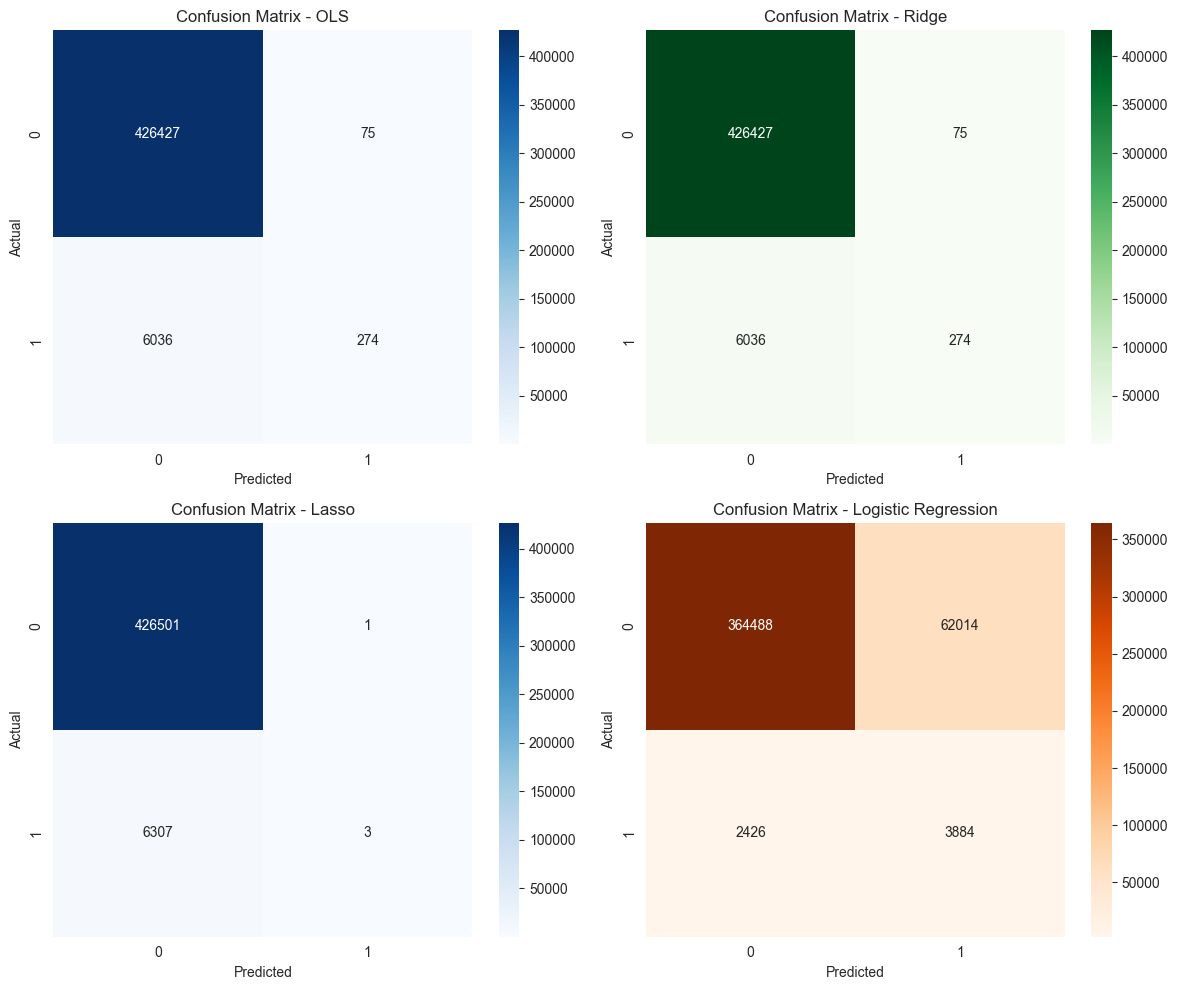

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.heatmap(cm_ols, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_xlabel('Predicted'); axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_title('Confusion Matrix - OLS')

sns.heatmap(cm_ridge, annot=True, fmt='d', cmap='Greens', ax=axes[0, 1])
axes[0, 1].set_xlabel('Predicted'); axes[0, 1].set_ylabel('Actual')
axes[0, 1].set_title('Confusion Matrix - Ridge')

sns.heatmap(cm_lasso, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_xlabel('Predicted'); axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_title('Confusion Matrix - Lasso')

sns.heatmap(cm_log, annot=True, fmt='d', cmap='Oranges', ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicted'); axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_title('Confusion Matrix - Logistic Regression')

fig.tight_layout()
plt.show()

#### Curves

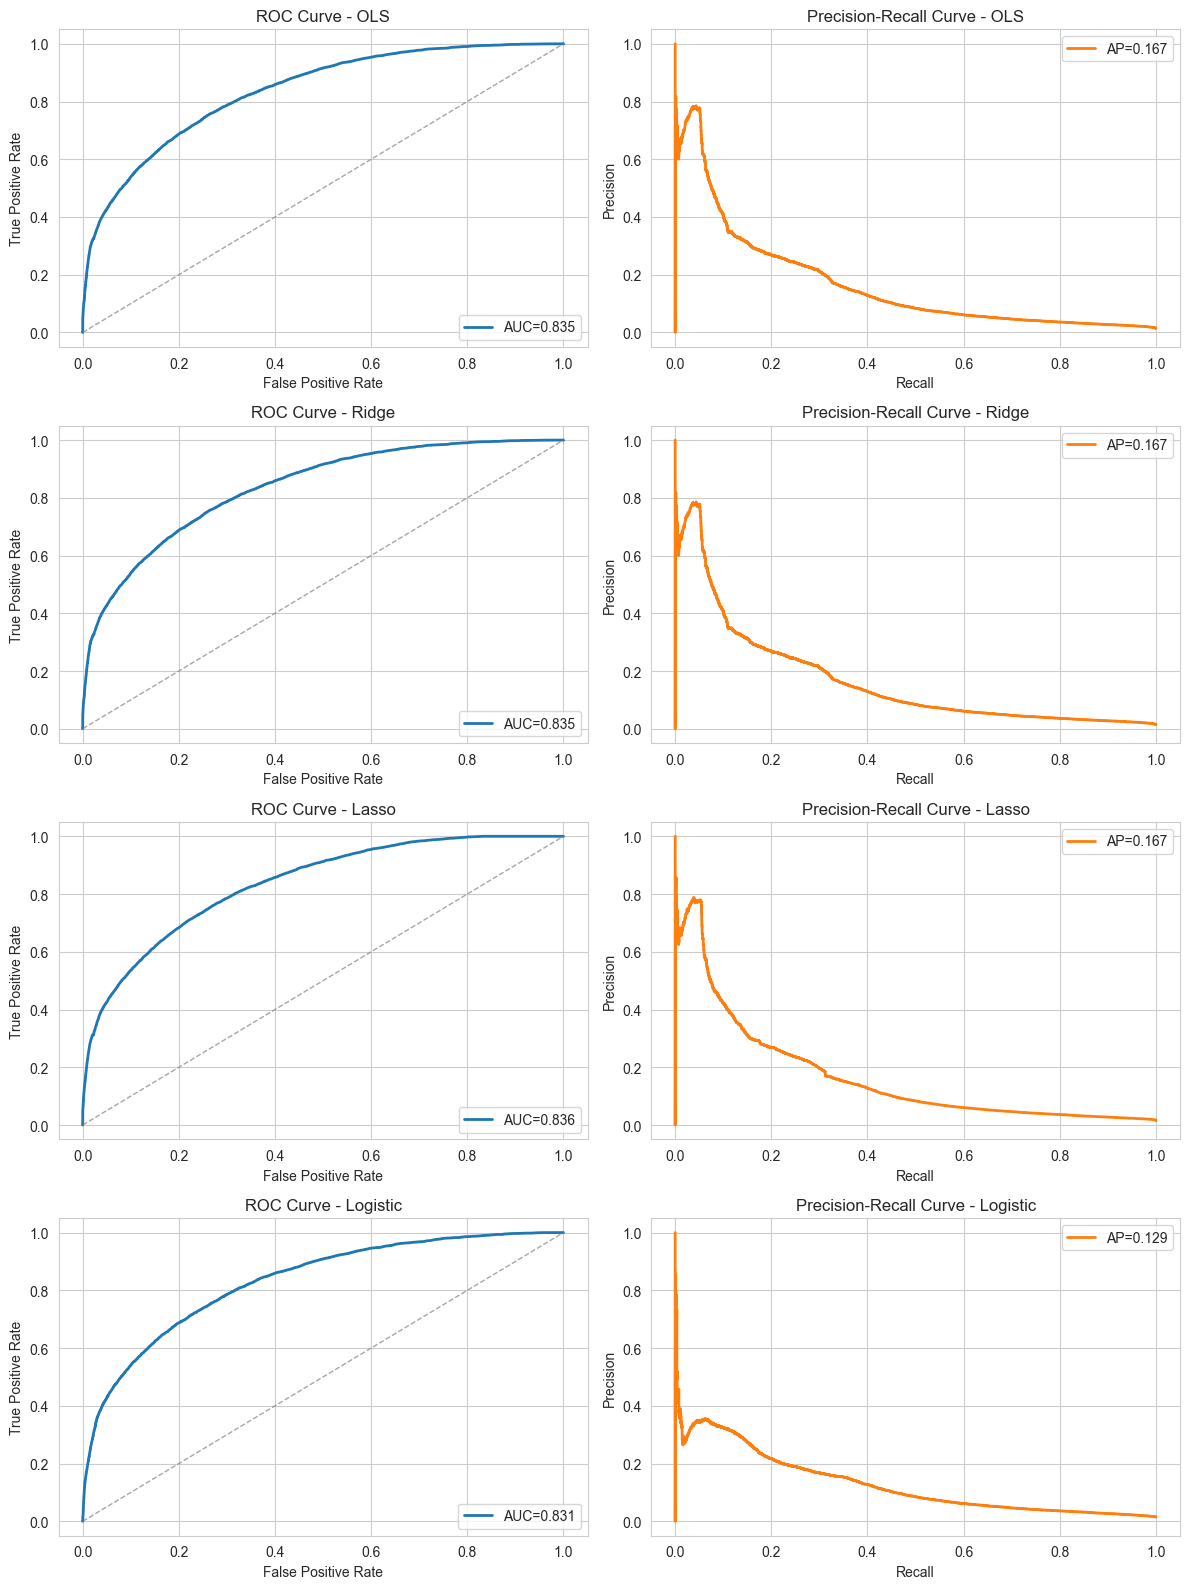

In [52]:
models = [
    ("OLS", y_val_pred_ols),
    ("Ridge", y_val_pred_r),
    ("Lasso", y_val_pred_lasso),
    ("Logistic", y_val_pred_log),
]

sns.set_style("whitegrid")
fig, axs = plt.subplots(len(models), 2, figsize=(12, 4 * len(models)))

for i, (name, y_pred) in enumerate(models):
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    precision, recall, _ = precision_recall_curve(y_val, y_pred)
    auc_ = roc_auc_score(y_val, y_pred)
    ap_ = average_precision_score(y_val, y_pred)

    ax_roc = axs[i, 0]
    ax_pr = axs[i, 1]

    ax_roc.plot(fpr, tpr, color="C0", lw=2, label=f"AUC={auc_:.3f}")
    ax_roc.plot([0, 1], [0, 1], color="grey", lw=1, linestyle="--", alpha=0.7)
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("True Positive Rate")
    ax_roc.set_title(f"ROC Curve - {name}")
    ax_roc.legend(loc="lower right")
    ax_roc.grid(True)

    ax_pr.plot(recall, precision, color="C1", lw=2, label=f"AP={ap_:.3f}")
    ax_pr.set_xlabel("Recall")
    ax_pr.set_ylabel("Precision")
    ax_pr.set_title(f"Precision-Recall Curve - {name}")
    ax_pr.legend(loc="upper right")
    ax_pr.grid(True)

fig.tight_layout()
plt.show()
